In [24]:
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble.forest import _generate_sample_indices
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import NearestNeighbors

from tqdm import tqdm

from itertools import permutations
import sys

import numpy as np
np.warnings.filterwarnings('ignore')

In [74]:
"""
This file contains code for conditional entropy forests. 
Adapted from https://github.com/rguo123/conditional_entropy_forests/blob/master/code/algorithm.py
"""

def finite_sample_correction(class_probs, row_sums):
    
    where_0 = np.argwhere(class_probs == 0)
    for elem in where_0:
        class_probs[elem[0], elem[1]] = 1 / (2 * row_sums[elem[0], None])
    where_1 = np.argwhere(class_probs == 1)
    for elem in where_1:
        class_probs[elem[0], elem[1]] = 1 - 1 / (2 * row_sums[elem[0], None])
    
    return class_probs

def build_model(X, y, n_estimators=200, max_samples=.32,
                                            bootstrap=True,
                                            depth=30,
                                            min_samples_leaf=1):
    if X.ndim == 1:
        raise ValueError('1d data will cause headaches down the road')
        
    max_features = int(np.ceil(np.sqrt(X.shape[1])))
        
    model=BaggingClassifier(DecisionTreeClassifier(max_depth=depth, min_samples_leaf=min_samples_leaf,
                                                     max_features = max_features),
                              n_estimators=n_estimators,
                              max_samples=max_samples,
                              bootstrap=bootstrap)
    
    model.fit(X, y)
    return model

def get_leaves(estimator):
    # adapted from https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html
    n_nodes = estimator.tree_.node_count
    children_left = estimator.tree_.children_left
    children_right = estimator.tree_.children_right
    feature = estimator.tree_.feature
    threshold = estimator.tree_.threshold
    
    leaf_ids = []
    stack = [(0, -1)] 
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()

        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            leaf_ids.append(node_id)
            
    return np.array(leaf_ids)

def estimate_posteriors(model, train, y, test, in_task=True, subsample=0, acorn=None):
    if acorn is None:
        acorn = np.random.randint(10**6)
    np.random.seed(acorn)
    
    n, d = train.shape
    m, d_ = test.shape
    
    if d != d_:
        raise ValueError("train and test data in different dimensions")
    
    class_counts = np.zeros((m, model.n_classes_))
    for tree in model:
        # get out of bag indicies
        if in_task:
            prob_indices = _generate_unsampled_indices(tree.random_state, n)
            # in_bag_idx = _generate_sample_indices(tree.random_state, n) # this is not behaving as i expected
        else:
            if subsample:
                prob_indices = np.random.choice(range(n), size=int(subsample*n), replace=False)
            else:
                prob_indices = range(n)
        
        leaf_nodes = get_leaves(tree)
        unique_leaf_nodes = np.unique(leaf_nodes)
            
        # get all node counts
        node_counts = tree.tree_.n_node_samples
        # get probs for eval samples
        posterior_class_counts = np.zeros((len(unique_leaf_nodes), model.n_classes_))

        for prob_index in prob_indices:
            temp_node = tree.apply(train[prob_index].reshape(1, -1)).item()
            posterior_class_counts[np.where(unique_leaf_nodes == temp_node)[0][0], y[prob_index]] += 1
            
        # total number of points in a node
        row_sums = posterior_class_counts.sum(axis=1)
        
        # no divide by zero
        row_sums[row_sums == 0] = 1

        # posteriors
        class_probs = (posterior_class_counts / row_sums[:, None])
        # posteriors with finite sampling correction
        
        class_probs = finite_sample_correction(class_probs, row_sums)
    
        # posteriors as a list
        class_probs.tolist()
        
        partition_counts = np.asarray([node_counts[np.where(unique_leaf_nodes == x)[0][0]] for x in tree.apply(test)])
        # get probability for out of bag samples
        eval_class_probs = [class_probs[np.where(unique_leaf_nodes == x)[0][0]] for x in tree.apply(test)]
        eval_class_probs = np.array(eval_class_probs)
        # find total elements for out of bag samples
        elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
        # store counts for each x (repeat fhis for each tree)
        class_counts += elems
    # calculate p(y|X = x) for all x's
    probs = class_counts / class_counts.sum(axis=1, keepdims=True)
    
    return probs

def predict(a):
    return np.argmax(a, axis = 1)

def permutation(predict1, predict2, force=False):
    """
    how to use:
    
    this function returns the permutation i.e. \pi: [K] -> [K] that maximizes
    the number of matched predictions
    
    to use the permutation for posteriors for point i (posterior_i), say, simply use
    posterior_i[permutation]
    
    """
    unique_1 = np.unique(predict1)
    unique_1_new = np.arange(len(unique_1))
    
    unique_2 = np.unique(predict2)
    unique_2_new = np.arange(len(unique_2))
    
    if force:
        for i, u in enumerate(unique_1_new):
            if u not in unique_2_new:
                unique_2_new = np.concatenate((unique_2_new, [u]))
        
        for i, u in enumerate(unique_2_new):
            if u not in unique_1_new:
                unique_1_new = np.concatenate((unique_1_new, [u]))
    else:
        if set(unique_1) != set(unique_2):
            raise ValueError("predictions must be on the same set of labels")
        
    K = len(unique_1_new)
    
    max_sum = 0
    max_perm = unique_2_new
    for i, perm in enumerate(permutations(unique_2_new)):
        perm = np.array(list(perm))
        temp_predict2 = -1*np.ones(len(predict2))
        
        for k in range(K):
            temp_predict2[np.where(predict2 == unique_2_new[k])[0]] = perm[k]
           
        temp_sum = np.sum(predict1 == temp_predict2)
        if temp_sum > max_sum:
            max_sum = temp_sum
            max_perm = perm
            
    return max_perm
            
def estimate_alpha(predict1, predict2, permutation=None):
    if permutation is None:
        return 2* (np.sum(predict1 == predict2) / len(predict1) - 0.5)
    else:
        unique = np.unique(predict2)
        unique_temp = np.unique(predict1)
        if len(unique) != len(unique_temp):
            unique = np.concatenate((unique, range(len(unique), len(unique) + len(unique_temp) - len(unique_temp))))
        temp_predict2 = -1*np.ones(len(predict2))
        
        for i, k in enumerate(unique):
            print(np.where(predict2 == k)[0])
            print(permutation[i])
            temp_predict2[np.where(predict2 == k)[0]] = permutation[i]
            
        return 2 * (np.sum(predict1 == temp_predict2) / len(predict1) - 0.5)
    
def generate_sample(n, pi, conditional_0, params0, conditional_1, params1, d = 2, acorn=None):
    if acorn is None:
        acorn = np.random.seed(10**6)
    np.random.seed(acorn)
    
    n0 = int(np.random.binomial(n, pi))
    n1 = n - n0
    ns = [n0, n1]
    
    X0 = conditional_0(*params0, size=(n0, d))
    
    X1 = conditional_1(*params1, size=(n1, d))
    
    labels = np.concatenate([i*np.ones(ns[i]) for i in range(len(ns))]).astype(int)
    
    return [np.concatenate((X0, X1), axis = 0), labels]

def generate_parity(n, d=2, invert_labels=False,acorn=None):
    if acorn is not None:
        np.random.seed(acorn)
        
    X = np.random.uniform(-1, 1, size=(n, d))
    Y = (np.sum(X > 0, axis=1) % 2 == 0).astype(int)
    
    if invert_labels:
        Y = -1 * (Y - 1)
    
    return X, Y.astype(int)

def parity_experiment(nx, nz, d, m, n_algos=6):
    Tx = int(np.floor(np.sqrt(nx)))
    Tz = int(np.floor(np.sqrt(nz)))
    
    Kx = int(np.floor(np.log(nx)))
    Kz = int(np.floor(np.log(nz)))
    
    errors = np.zeros(n_algos)
    
    temp_predictions = [[] for __ in range(n_algos)]
    
    # Sum
    Z, labelsZ = generate_parity(nz + nx, d, invert_labels=True)
    testZ, test_labelsZ = generate_parity(m, d, invert_labels=True)
    
    model_best = build_model(Z, labelsZ, int(np.floor(np.sqrt(nx + nz))))
    
    posteriors_best=estimate_posteriors(model_best, Z, labelsZ, testZ, in_task=True)
    predictions_best=predict(posteriors_best)
    
    errors[-1] = 1 - np.sum(test_labelsZ == predictions_best)/m

    # Source task
    X, labelsX = generate_parity(nx, d)
    testX, test_labelsX = generate_parity(m, d)

    
    # Target task
    Z, labelsZ = generate_parity(nz, d, invert_labels=True)
    testZ, test_labelsZ = generate_parity(m, d, invert_labels=True)


    model_X = build_model(X, labelsX, Tx)
    model_Z = build_model(Z, labelsZ, Tz)

    posteriors_structX_estX=estimate_posteriors(model_X, X, labelsX, testX, in_task=True)
    posteriors_structZ_estX=estimate_posteriors(model_Z, X, labelsX, testX, in_task=False, subsample=1-0.32)

    pred_structX_estX=predict(posteriors_structX_estX)
    pred_structZ_estX=predict(posteriors_structZ_estX)

    posteriors_structX_estZ=estimate_posteriors(model_X, Z, labelsZ, testZ, in_task=False, subsample=1-0.32)
    posteriors_structZ_estZ=estimate_posteriors(model_Z, Z, labelsZ, testZ, in_task=True)
    
    pred_structX_estZ=predict(posteriors_structX_estZ)
    pred_structZ_estZ=predict(posteriors_structZ_estZ)

    # calculate errors without attempting to transfer knowledge
    pred_X = predict(posteriors_structX_estX)
    pred_Z = predict(posteriors_structZ_estZ)

    errors[0] = 1 - np.sum(test_labelsX == pred_X)/m
    errors[1] = 1 - np.sum(test_labelsZ == pred_Z)/m
    
    errors[2] = 1 - np.sum(test_labelsX == pred_structZ_estX)/m
    errors[3] = 1 - np.sum(test_labelsZ == pred_structX_estZ)/m
    
    

    # jtv ?
    pred_X_jtv = predict(posteriors_structX_estX + posteriors_structZ_estX)
    pred_Z_jtv = predict(posteriors_structZ_estZ + posteriors_structX_estZ)

    errors[4] = 1 - np.sum(test_labelsX == pred_X_jtv)/m
    errors[5] = 1 - np.sum(test_labelsZ == pred_Z_jtv)/m
    
    # now using local estimates..
#     new_posteriors_structX_estZ_local = np.zeros(posteriors_structX_estZ.shape)
#     new_posteriors_structZ_estX_local = np.zeros(posteriors_structZ_estX.shape)

#     kNN_X = NearestNeighbors(n_neighbors=Kx).fit(testX)    
#     kNN_Z = NearestNeighbors(n_neighbors=Kz).fit(testZ)

#     alpha_X_local = np.zeros(m)
#     for k, obs in enumerate(testX):
#         obs = obs.reshape(1, -1)
#         temp_neighbors = kNN_X.kneighbors(obs)[1]

#         temp_preds_structX_estX = pred_structX_estX[temp_neighbors]
#         temp_preds_structZ_estX = pred_structZ_estX[temp_neighbors]

#         temp_permutation = permutation(temp_preds_structX_estX, temp_preds_structZ_estX, force=True)

#         pred_structZ_estX_local = predict(new_posteriors_structZ_estX_local)

#         alpha_X_local[k] = estimate_alpha(pred_structZ_estX_local, pred_structX_estX)
#         new_posteriors_structZ_estX_local[k] = alpha_X_local[k]*posteriors_structZ_estX[k][temp_permutation]

#     alpha_Z_local = np.zeros(m)
#     for k, obs in enumerate(testZ):
#         obs = obs.reshape(1, -1)
#         temp_neighbors = kNN_Z.kneighbors(obs)[1]

#         temp_preds_structX_estZ = pred_structX_estZ[temp_neighbors]
#         temp_preds_structZ_estZ = pred_structZ_estZ[temp_neighbors]

#         temp_permutation = permutation(temp_preds_structX_estZ, temp_preds_structZ_estZ, force=True)
#         pred_structX_estZ_local = predict(new_posteriors_structX_estZ_local)

#         alpha_Z_local[k] = estimate_alpha(pred_structZ_estZ, pred_structX_estZ_local)
#         new_posteriors_structX_estZ_local[k] = alpha_Z_local[k]*posteriors_structX_estZ[k][temp_permutation]

#     pred_X_cep_local = predict(posteriors_structX_estX +  new_posteriors_structZ_estX_local)
#     pred_Z_cep_local = predict(posteriors_structZ_estZ + new_posteriors_structX_estZ_local)

    
#     print("X:" + str(pred_X_cep_local))
#     errors[6] = 1 - np.sum(test_labelsX == pred_X_cep_local)/m
#     print("Z:" + str(pred_Z_cep_local))
#     errors[7] = 1 - np.sum(test_labelsZ == pred_Z_cep_local)/m

    return errors

In [106]:
def jovo_experiment(nx, nz, d, dist_x=generate_parity, dist_z=generate_parity, m=100, target="Z", subsample = 0.32, n_algos=6):
    if target == "Z":
        invert_z = True
        invert_x = False
    else:
        invert_z = False
        invert_x = True
        
    Tx = int(np.floor(np.sqrt(nx)))
    Tz = int(np.floor(np.sqrt(nz)))
    
    Kx = int(np.floor(np.log(nx)))
    Kz = int(np.floor(np.log(nz)))
    
    errors = np.zeros(n_algos)

    # Source task
    X, labelsX = dist_x(nx, d, invert_labels=invert_x)
    testX, test_labelsX = dist_x(m, d, invert_labels=invert_x)

    
    # Target task
    Z, labelsZ = dist_z(nz, d, invert_labels=invert_z)
    testZ, test_labelsZ = dist_z(m, d, invert_labels=invert_z)


    model_X = build_model(X, labelsX, Tx)
    model_Z = build_model(Z, labelsZ, Tz)

    posteriors_structX_estX=estimate_posteriors(model_X, X, labelsX, testX, in_task=True)
    posteriors_structZ_estX=estimate_posteriors(model_Z, X, labelsX, testX, in_task=False, subsample=subsample)

    pred_structX_estX=predict(posteriors_structX_estX)
    pred_structZ_estX=predict(posteriors_structZ_estX)

    posteriors_structX_estZ=estimate_posteriors(model_X, Z, labelsZ, testZ, in_task=False, subsample=subsample)
    posteriors_structZ_estZ=estimate_posteriors(model_Z, Z, labelsZ, testZ, in_task=True)
    
    pred_structX_estZ=predict(posteriors_structX_estZ)
    pred_structZ_estZ=predict(posteriors_structZ_estZ)

    # calculate errors without attempting to transfer knowledge
    pred_X = predict(posteriors_structX_estX)
    pred_Z = predict(posteriors_structZ_estZ)

    errors[0] = 1 - np.sum(test_labelsX == pred_X)/m
    errors[3] = 1 - np.sum(test_labelsZ == pred_Z)/m
    
#     errors[1] = 1 - np.sum(test_labelsX == pred_structZ_estX)/m
#     errors[4] = 1 - np.sum(test_labelsZ == pred_structX_estZ)/m

    # jtv ?
    pred_X_jtv = predict(posteriors_structX_estX + posteriors_structZ_estX)
    pred_Z_jtv = predict(posteriors_structZ_estZ + posteriors_structX_estZ)

    errors[1] = 1 - np.sum(test_labelsX == pred_X_jtv)/m
    errors[4] = 1 - np.sum(test_labelsZ == pred_Z_jtv)/m
    
    # Sum
    X, labelsX = dist_x(nz + nx, d, invert_labels=invert_x)
#     testX, test_labelsX = dist_x(m, d, invert_labels=invert_x)
    
    model_best_X = build_model(X, labelsX, int(np.floor(np.sqrt(nx + nz))))
    
    posteriors_best_X=estimate_posteriors(model_best_X, X, labelsX, testX, in_task=True)
    predictions_best_X=predict(posteriors_best_X)
    
    errors[2] = 1 - np.sum(test_labelsX == predictions_best_X)/m
    
    # Sum
    Z, labelsZ = dist_z(nz + nx, d, invert_labels=invert_z)
#     testZ, test_labelsZ = dist_z(m, d, invert_labels=invert_z)
    
    model_best_Z = build_model(Z, labelsZ, int(np.floor(np.sqrt(nx + nz))))
    
    posteriors_best_Z=estimate_posteriors(model_best_Z, Z, labelsZ, testZ, in_task=True)
    predictions_best_Z=predict(posteriors_best_Z)
    
    errors[5] = 1 - np.sum(test_labelsZ == predictions_best_Z)/m
    
    # now using local estimates..
#     new_posteriors_structX_estZ_local = np.zeros(posteriors_structX_estZ.shape)
#     new_posteriors_structZ_estX_local = np.zeros(posteriors_structZ_estX.shape)

#     kNN_X = NearestNeighbors(n_neighbors=Kx).fit(testX)    
#     kNN_Z = NearestNeighbors(n_neighbors=Kz).fit(testZ)

#     alpha_X_local = np.zeros(m)
#     for k, obs in enumerate(testX):
#         obs = obs.reshape(1, -1)
#         temp_neighbors = kNN_X.kneighbors(obs)[1]

#         temp_preds_structX_estX = pred_structX_estX[temp_neighbors]
#         temp_preds_structZ_estX = pred_structZ_estX[temp_neighbors]

#         temp_permutation = permutation(temp_preds_structX_estX, temp_preds_structZ_estX, force=True)
#         print(temp_permutation)

#         pred_structZ_estX_local = predict(new_posteriors_structZ_estX_local)
        
#         alpha_X_local[k] = estimate_alpha(pred_structZ_estX_local, pred_structX_estX, temp_permutation)
#         new_posteriors_structZ_estX_local[k] = alpha_X_local[k]*posteriors_structZ_estX[k][temp_permutation]
#     print(alpha_X_local)

#     alpha_Z_local = np.zeros(m)
#     for k, obs in enumerate(testZ):
#         obs = obs.reshape(1, -1)
#         temp_neighbors = kNN_Z.kneighbors(obs)[1]

#         temp_preds_structX_estZ = pred_structX_estZ[temp_neighbors]
#         temp_preds_structZ_estZ = pred_structZ_estZ[temp_neighbors]

#         temp_permutation = permutation(temp_preds_structX_estZ, temp_preds_structZ_estZ, force=True)
#         pred_structX_estZ_local = predict(new_posteriors_structX_estZ_local)

#         alpha_Z_local[k] = estimate_alpha(pred_structZ_estZ, pred_structX_estZ_local)
#         new_posteriors_structX_estZ_local[k] = alpha_Z_local[k]*posteriors_structX_estZ[k][temp_permutation]

#     pred_X_cep_local = predict(posteriors_structX_estX + new_posteriors_structZ_estX_local)
#     pred_Z_cep_local = predict(posteriors_structZ_estZ + new_posteriors_structX_estZ_local)

#     errors[6] = 1 - np.sum(test_labelsX == pred_X_cep_local)/m
#     errors[7] = 1 - np.sum(test_labelsZ == pred_Z_cep_local)/m

    return errors

In [76]:
jovo_experiment(500, 500, d, m=m, n_algos=M)

[0 1]
[ 6  8  9 11 17 18 19 25 26 29 31 32 33 35 36 38 40 41 42 43 44 48 50 52
 61 65 68 69 71 73 74 75 76 78 80 81 83 84 87 88 91 92 95 98 99]
0
[ 0  1  2  3  4  5  7 10 12 13 14 15 16 20 21 22 23 24 27 28 30 34 37 39
 45 46 47 49 51 53 54 55 56 57 58 59 60 62 63 64 66 67 70 72 77 79 82 85
 86 89 90 93 94 96 97]
1
[0 1]
[ 6  8  9 11 17 18 19 25 26 29 31 32 33 35 36 38 40 41 42 43 44 48 50 52
 61 65 68 69 71 73 74 75 76 78 80 81 83 84 87 88 91 92 95 98 99]
0
[ 0  1  2  3  4  5  7 10 12 13 14 15 16 20 21 22 23 24 27 28 30 34 37 39
 45 46 47 49 51 53 54 55 56 57 58 59 60 62 63 64 66 67 70 72 77 79 82 85
 86 89 90 93 94 96 97]
1
[0 1]
[ 6  8  9 11 17 18 19 25 26 29 31 32 33 35 36 38 40 41 42 43 44 48 50 52
 61 65 68 69 71 73 74 75 76 78 80 81 83 84 87 88 91 92 95 98 99]
0
[ 0  1  2  3  4  5  7 10 12 13 14 15 16 20 21 22 23 24 27 28 30 34 37 39
 45 46 47 49 51 53 54 55 56 57 58 59 60 62 63 64 66 67 70 72 77 79 82 85
 86 89 90 93 94 96 97]
1
[0 1]
[ 6  8  9 11 17 18 19 25 26 29 31 32 33 35 

IndexError: index 1 is out of bounds for axis 0 with size 1

In [108]:
from tqdm import tqdm
np.random.seed(1)
from joblib import Parallel, delayed

mc_its = 100 # number of simulation repititions
# ns0 = (10*np.arange(3,5,step=1)).astype(int)
ns = (100*np.arange(1, 4, step=0.5)).astype(int) # number of training samples 
nz_prop = 1

m = 100 # number of test samples each monte carlo iteration

algorithms = ['R^{(1)} (Z^{(1)})', 'R^{(1)} (Z^{(1)}, Z^{(2)})', 'R^{(1)} (n1 + n2)']
algorithms = np.concatenate((algorithms, ['R^{(2)} (Z^{(2)})', 'R^{(2)} (Z^{(1)}, Z^{(2)})', 'R^{(2)} (n1 + n2)']))
# algorithms = np.concatenate((algorithms, ['R^{(1)} (n1 + n2)', 'R^{(2)} (n1 + n2)']))
# algorithms = np.concatenate((algorithms, ['CEP LOCAL (1)', 'CEP LOCAL (2)']))

M = len(algorithms)

mean_error = np.zeros((M, len(ns)))
std_error = np.zeros((M, len(ns)))

d = 2
for j, n in enumerate(tqdm(ns)):
    condensed_func = lambda x : jovo_experiment(200, x, d, m=m, n_algos=M)
    
    errors = np.array(Parallel(n_jobs=-2)(delayed(condensed_func)(int(x)) for x in n*np.ones(mc_its)))
    
    mean_error[:, j] = np.mean(errors, axis=0)
    std_error[:, j] = np.std(errors, ddof=1, axis=0)

100%|██████████| 6/6 [00:15<00:00,  2.85s/it]


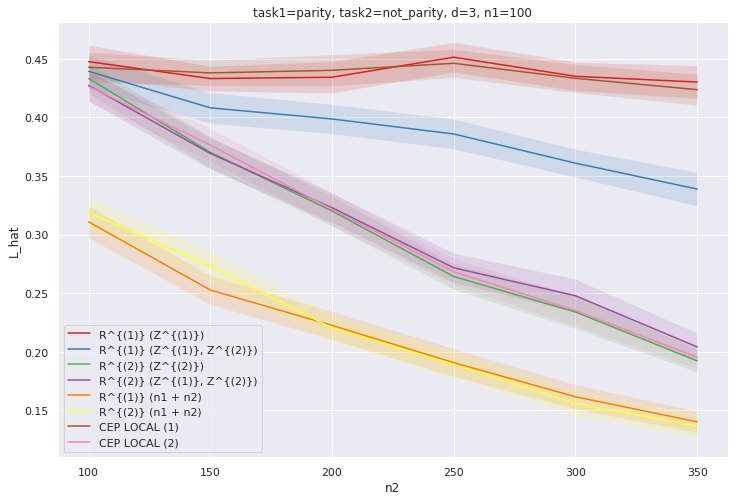

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

mc_it = mc_its

sns.set()
colors = sns.color_palette("Set1", n_colors = M)
fig, ax = plt.subplots(1,1, figsize = (12, 8))
    
algo_offset=0
for i, algo in enumerate(algorithms[algo_offset:]):
    ax.plot(ns, mean_error[i + algo_offset], label=algo, c=colors[i])
    ax.fill_between(ns, 
            mean_error[i + algo_offset] + 1.96*std_error[i + algo_offset]/np.sqrt(mc_it), 
            mean_error[i + algo_offset] - 1.96*std_error[i + algo_offset]/np.sqrt(mc_it), 
            where=mean_error[i + algo_offset] + 1.96*std_error[i + algo_offset]/np.sqrt(mc_it) >= mean_error[i + algo_offset] - 1.96*std_error[i + algo_offset]/np.sqrt(mc_it), 
            facecolor=colors[i], 
            alpha=0.15,
            interpolate=True)
ax.legend()
ax.set_xlabel('n2')
ax.set_ylabel('L_hat')

ax.set_title('task1=parity, task2=not_parity, d=%i, n1=100'%(d))
plt.savefig('parity_not_parity_CEP_n100.png')

In [35]:
from tqdm import tqdm
np.random.seed(1)
from joblib import Parallel, delayed

mc_its = 100 # number of simulation repititions
# ns0 = (10*np.arange(3,5,step=1)).astype(int)
ns = (100*np.arange(1, 4, step=0.5)).astype(int) # number of training samples 
nz_prop = 1

m = 100 # number of test samples each monte carlo iteration

algorithms = ['R^{(1)} (Z^{(1)})', 'R^{(1)} (Z^{(1)}, Z^{(2)})']
algorithms = np.concatenate((algorithms, ['R^{(2)} (Z^{(2)})', 'R^{(2)} (Z^{(1)}, Z^{(2)})']))
algorithms = np.concatenate((algorithms, ['R^{(1)} (n1 + n2)', 'R^{(2)} (n1 + n2)']))
# algorithms = np.concatenate((algorithms, ['CEP LOCAL (1)', 'CEP LOCAL (2)']))

M = len(algorithms)

mean_error = np.zeros((M, len(ns)))
std_error = np.zeros((M, len(ns)))

d = 3
for j, n in enumerate(tqdm(ns)):
    condensed_func = lambda x : jovo_experiment(200, x, d, m=100, n_algos=M)
    
    errors = np.array(Parallel(n_jobs=-2)(delayed(condensed_func)(int(x)) for x in n*np.ones(mc_its)))
    
    mean_error[:, j] = np.mean(errors, axis=0)
    std_error[:, j] = np.std(errors, ddof=1, axis=0)

100%|██████████| 6/6 [00:20<00:00,  3.67s/it]


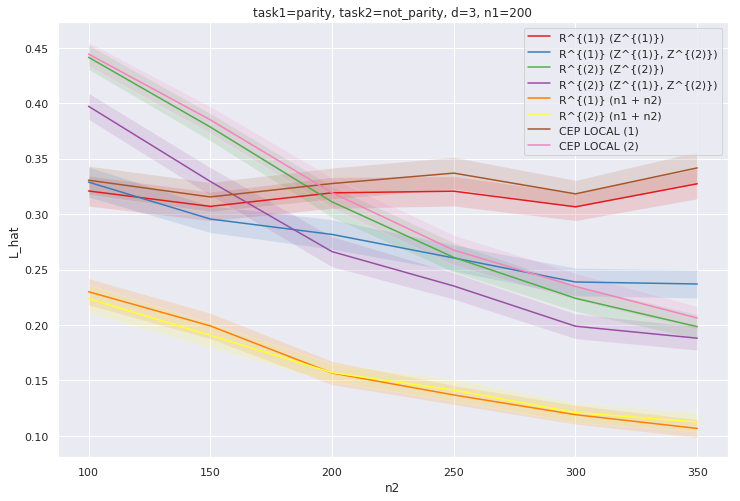

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

mc_it = mc_its

sns.set()
colors = sns.color_palette("Set1", n_colors = M)
fig, ax = plt.subplots(1,1, figsize = (12, 8))
    
algo_offset=0
for i, algo in enumerate(algorithms[algo_offset:]):
    ax.plot(ns, mean_error[i + algo_offset], label=algo, c=colors[i])
    ax.fill_between(ns, 
            mean_error[i + algo_offset] + 1.96*std_error[i + algo_offset]/np.sqrt(mc_it), 
            mean_error[i + algo_offset] - 1.96*std_error[i + algo_offset]/np.sqrt(mc_it), 
            where=mean_error[i + algo_offset] + 1.96*std_error[i + algo_offset]/np.sqrt(mc_it) >= mean_error[i + algo_offset] - 1.96*std_error[i + algo_offset]/np.sqrt(mc_it), 
            facecolor=colors[i], 
            alpha=0.15,
            interpolate=True)
ax.legend()
ax.set_xlabel('n2')
ax.set_ylabel('L_hat')

ax.set_title('task1=parity, task2=not_parity, d=%i, n1=200'%(d))
plt.savefig('parity_not_parity_CEP_n200.png')

In [172]:
X, labelsX = generate_parity(500, 2)
temp_labelsX = []
# testX, test_labelsX = generate_parity(m, d)
    


# Target task
Z, labelsZ = generate_parity(500, 2, invert_labels=True)
temp_labelsZ = []
# testZ, test_labelsZ = generate_parity(m, d, invert_labels=True)

for i in range(len(labelsX)):
    if labelsX[i] == 0:
        temp_labelsX.append('k')
    else:
        temp_labelsX.append('pink')
        
    if labelsZ[i] == 0:
        temp_labelsZ.append('k')
    else:
        temp_labelsZ.append('pink')


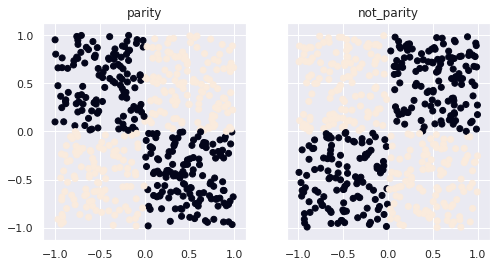

In [145]:
fig, ax = plt.subplots(1,2, sharex=True, sharey=True, figsize = (12,6))
ax[0].scatter(X[:, 0], X[:, 1], c = labelsX)
ax[1].scatter(Z[:, 0], Z[:, 1], c = labelsZ)
ax[0].set_title('parity')
ax[1].set_title('not_parity')
# plt.savefig('parity_not_parity_plots.png')

In [170]:
from tqdm import tqdm
np.random.seed(1)
from joblib import Parallel, delayed

mc_its = 100 # number of simulation repititions
# ns0 = (10*np.arange(3,5,step=1)).astype(int)
ns = (100*np.arange(0.5, 6.5, step=0.5)).astype(int) # number of training samples 
nz_prop = 1

m = 100 # number of test samples each monte carlo iteration

algorithms = ['Decision Forest Source', 'Lifelong Forests Source', 'Optimal Forest']
algorithms = np.concatenate((algorithms, ['Decision Forest Target', 'Lifelong Forests Target', 'Optimal Forest']))
# algorithms = np.concatenate((algorithms, ['R^{(1)} (n1 + n2)', 'R^{(2)} (n1 + n2)']))
# algorithms = np.concatenate((algorithms, ['CEP LOCAL (1)', 'CEP LOCAL (2)']))

M = len(algorithms)

In [155]:
mean_error = np.zeros((M, len(ns)))
std_error = np.zeros((M, len(ns)))

d = 3
for j, n in enumerate(tqdm(ns)):
    condensed_func = lambda x : jovo_experiment(200, x, d, m=m, n_algos=M)
    
    errors = np.array(Parallel(n_jobs=-2)(delayed(condensed_func)(int(x)) for x in n*np.ones(mc_its)))
    
    mean_error[:, j] = np.mean(errors, axis=0)
    std_error[:, j] = np.std(errors, ddof=1, axis=0)


100%|██████████| 12/12 [00:42<00:00,  4.88s/it]

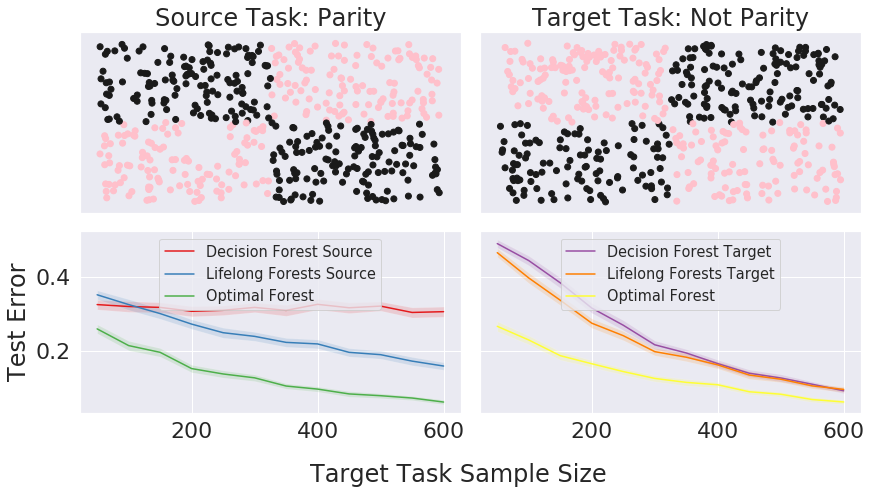

In [205]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

gs1 = gridspec.GridSpec(4, 4)
sns.set()

mc_it = mc_its

sns.set(font_scale=2)
colors = sns.color_palette("Set1", n_colors = M)
fig1, ax = plt.subplots(2,2, figsize = (14, 7), sharex = 'row', sharey='row')

# fig, ax = plt.subplots(1,2, sharex=True, sharey=True, figsize = (8,4))
ax[0,0].scatter(X[:, 0], X[:, 1], c = temp_labelsX)
ax[0,1].scatter(Z[:, 0], Z[:, 1], c = temp_labelsZ)


ax[0,0].set_title('Source Task: Parity')
ax[0,1].set_title('Target Task: Not Parity')
    
algo_offset=0
for i, algo in enumerate(algorithms[algo_offset:-3]):
    ax[1,0].plot(ns, mean_error[i + algo_offset], label=algo, c=colors[i])
    ax[1,0].fill_between(ns, 
            mean_error[i + algo_offset] + 1.96*std_error[i + algo_offset]/np.sqrt(mc_it), 
            mean_error[i + algo_offset] - 1.96*std_error[i + algo_offset]/np.sqrt(mc_it), 
            where=mean_error[i + algo_offset] + 1.96*std_error[i + algo_offset]/np.sqrt(mc_it) >= mean_error[i + algo_offset] - 1.96*std_error[i + algo_offset]/np.sqrt(mc_it), 
            facecolor=colors[i], 
            alpha=0.15,
            interpolate=True)
    
algo_offset=3
for i, algo in enumerate(algorithms[algo_offset:]):
    ax[1,1].plot(ns, mean_error[i + algo_offset], label=algo, c=colors[i + algo_offset])
    ax[1,1].fill_between(ns, 
            mean_error[i + algo_offset] + 1.96*std_error[i + algo_offset]/np.sqrt(mc_it), 
            mean_error[i + algo_offset] - 1.96*std_error[i + algo_offset]/np.sqrt(mc_it), 
            where=mean_error[i + algo_offset] + 1.96*std_error[i + algo_offset]/np.sqrt(mc_it) >= mean_error[i + algo_offset] - 1.96*std_error[i + algo_offset]/np.sqrt(mc_it), 
            facecolor=colors[i +algo_offset], 
            alpha=0.15,
            interpolate=True)
ax[1,0].legend(loc='upper center', fontsize=14.5)
ax[1,1].legend(loc='upper center', fontsize=14.5)
ax[1,0].set_ylabel('Test Error')
ax[0,1].set_xticks([])
ax[0,1].set_yticks([])

fig1.subplots_adjust(wspace=0.05, hspace=0.1)

fig1.text(0.5, -0.0125, 'Target Task Sample Size', ha='center')
# ax[0].set_title('task1=parity, task2=not_parity, d=%i, n1=200'%(d))
plt.savefig('vip_results_parity_not_parity_n200.pdf')